{'Date': ['2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16', '2022-12-17', '2022-12-18', '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27'], 'daily_mean_rain': array([16.17777824,  6.12222147,  0.68888891,  0.22222222,  4.43111134,
        9.72222233,  7.58888912,  4.58888865,  1.5999999 ,  1.62222219,
        1.30000007,  1.56666672,  2.18888903,  2.85555553,  5.57777834,
        5.18888903])}


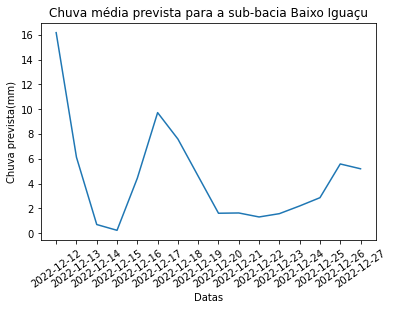

In [10]:
#Libs
import shapefile as shp
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import rioxarray
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import datetime as dt

#Data path
data_path = "/arquivos"

#Read shapefile
baixo_iguacu = shp.Reader(f'{data_path}/baixo_iguacu.shp')

#Read netcdf
ds_p = xr.open_dataset(f'{data_path}/precip-total_GEFSav_glob_20221212T00.nc')

#Longitude adjustment
ds_p.coords['lon'] = ((ds_p.coords['lon'] + 180) % 360) - 180
ds_p = ds_p.sortby(ds_p.lon)

#Using shapefile as mask
ds_p.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds_p.rio.write_crs("epsg:4326", inplace=True)
Shapefile = gpd.read_file('baixo_iguacu.shp', crs="epsg:4326")

clipped = ds_p.rio.clip(Shapefile.geometry.apply(mapping), Shapefile.crs, drop=False)

#Format dates function
def format_dates(dates):
    dt_data = pd.to_datetime(dates)
    try: return [dt.datetime(x.year, x.month, x.day, x.hour, x.second) for x in dt_data]    
    except TypeError: return dt.datetime(dt_data.year, dt_data.month, dt_data.day, dt_data.hour, dt_data.second)

day1 = clipped.time[0].values
run_date = format_dates(day1).date()

#Transfom ndarray
tp = clipped.tp.values

#Variables with 16 days
daily_areamean = np.array([0.0] * 16)
dates = ([0.0] * 16)

#n times by day
n = 4

#Calculation
for h in range(16):
    inicio = h * n
    fim = inicio + n
    daily_sum = np.nansum(tp[inicio:fim], axis=0)
    
    daily_sum[np.isnan(tp[0])] = np.nan
    daily_areamean[h] = np.nanmean(daily_sum)
    
    dates[h] = str(run_date + dt.timedelta(days=h))

#Result
result = {}
result[f'Date']                = dates
result[f'daily_mean_rain']     = daily_areamean
#print(dates)
#print(daily_areamean)
print(result)

#Plot
# -*- coding: utf-8 -*-
x = dates
y = daily_areamean

titulo = "Chuva média prevista para a sub-bacia Baixo Iguaçu"
eixox = "Datas"
eixoy = "Chuva prevista(mm)"

#legendas
plt.title(titulo)
plt.xlabel(eixox)
plt.ylabel(eixoy)

plt.plot(x,y)
plt.xticks(rotation = 35) 
plt.show()